In [1]:
# import
from utils_2.Custom_YOLOv7 import custom_yolov7
from utils_2.mAP_utils import show_matplot, Txt2dic_list
import os
import shutil
import cv2
import random
from tqdm import tqdm
from natsort import natsorted
import matplotlib.pyplot as plt

이미지에 매칭되는 레이블 옮기기

In [3]:
path = './datasets/240604_UpDown_view_compare_test'

for view in ['up_view', 'down_view']:
    for name in ['cable', 'poop']:
        img_list = os.listdir(f'{path}/{view}/{name}')
        for img_name in tqdm(img_list):
            # 레이블 찾아서 경로 설정
            label_name = f'{img_name.split(".")[0]}.txt'
            from_path = f'{path}/labels/{label_name}'
            to_path = f'{path}/{view}/{name}/{label_name}'
            shutil.move(from_path, to_path)

100%|██████████| 119/119 [00:00<00:00, 1507.00it/s]


테스트 인퍼런스

In [3]:
# 모델 선언
model = custom_yolov7(model_path='./weights/240605_best.pt', img_size={'w':416,'h':320})


                 from  n    params  module                                  arguments                     
  0                -1  1       928  models.common.Conv                      [3, 32, 3, 1]                 
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  5                -2  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 


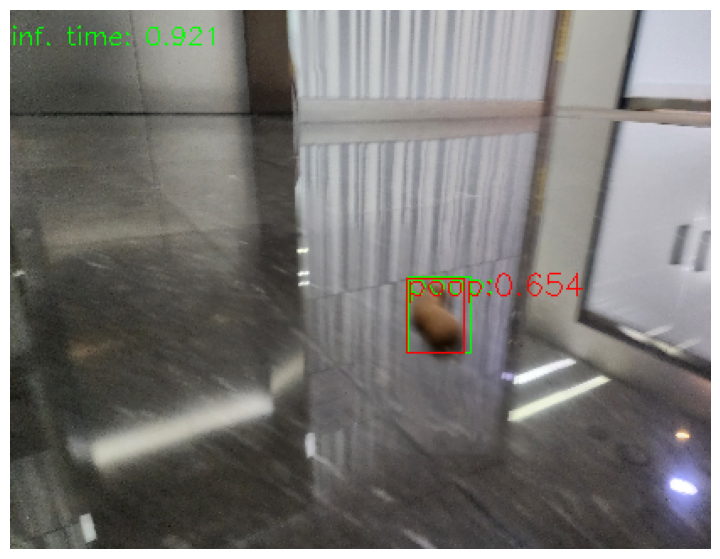

In [4]:
%matplotlib inline

dataset_path = './datasets/240604_UpDown_view_compare_test'
random_view = ['up_view', 'down_view'][random.randint(0,1)]
random_class = ['cable', 'poop'][random.randint(0,1)]

# 랜덤한 이미지 list 만들기
file_list = os.listdir(f'{dataset_path}/{random_view}/{random_class}')
img_list = []
for file_name in file_list:
    if '.jpg' in file_name:
        img_list.append(f'{dataset_path}/{random_view}/{random_class}/{file_name}')

# 인퍼런스
file_path = img_list[random.randint(0, len(img_list)-1)]
random_img = cv2.imread(file_path)
dic_list = model.detect(random_img, conf_thresh=0.1, filter=[random_class])

# 그리기 - Ground Truth
class_list = ['cable', 'carpet', 'cloth', 'liquid', 'poop', 'rack', 'scale', 'socks', 'towel', 'book'] # data.yaml
img_size = {'w':416, 'h':320}
txt2dic_list = Txt2dic_list(class_list, img_size)
label_name = f'{file_path.split("/")[-1].split(".")[0]}.txt'
dic_list_gt = txt2dic_list.transform(f'{dataset_path}/{random_view}/{random_class}/{label_name}')
draw_img = model.draw(model.resize_img, dic_list_gt, color=(0,255,0))

# 그리기 - 인퍼런스
draw_img = model.draw(draw_img, dic_list, color=(0,0,255))

# show
show_matplot(draw_img, img_size={'w':416,'h':320})

mAP 계산

In [5]:
import numpy as np
import cv2

class Calculate_mAP:
    def __init__(self, class_list, img_size, iou_thresh=0.5):
        '''
        GT와 추론 결과를 넣으면 AP를 계산해주는 함수
        '''
        self.class_dic = {}
        for i, name in enumerate(class_list):
            self.class_dic[i] = name
        self.img_size = img_size
        self.iou_thresh = iou_thresh

    def process(self, gt_and_inf_list):
        '''
        순서대로 PR커브 그리고 아래 면적 계산하여 AP 반환해주는 함수
        '''
        # 판별 리스트 만들기
        confusion_matrix_list = self.make_confusion_matrix(gt_and_inf_list)
        # 리스트 및 변수 초기화
        tp, fp = 0, 0
        precision_list, recall_list = [], []
        total_gt = 0 # recall 도출에 필요
        for result in gt_and_inf_list:
            total_gt += len(result['dic_list_gt'])
        # pr커브 그리는데 필요 정보 제작
        for result in confusion_matrix_list:
            if result['result'] == 'TP':
                tp += 1
            elif result['result'] == 'FP':
                fp += 1
            else:
                print('TP, FP 판별 오류')
            precision_list.append(tp / (tp + fp))
            recall_list.append(tp / total_gt)
        # pr_curve, AP 구하기
        pr_curve = self.get_pr_curve(precision_list, recall_list)
        AP = self.get_AP(precision_list, recall_list)
        return pr_curve, AP

    def make_confusion_matrix(self, gt_and_inf_list):
        '''
        pred와 gt결과를 분석하여 tp, fp로 이루어진 conf가 포함된 리스트를 만들고 conf 기준으로 내림차순 정렬하여 반환
        TP: 결과를 제대로 예측함
        FP: 결과가 정답 iou를 벗어나거나, 다른 사물로 예측함
        FN: GT에 있지만 예측을 못함 -> GT - TP
        TN: 존재하지 않음(사물인식에서 없는 것을 없는 것으로 예측한 개수를 샐 수 없음)
        '''
        # 판별 리스트 만들기
        confusion_matrix_list = []
        for result in gt_and_inf_list: # 한 장에 대한 pred와 gt값
            # TP, FP 계산
            for pred in result['dic_list']:
                tp_found = False
                for i, gt in enumerate(result['dic_list_gt']):
                    if self.calculate_iou(pred['bbox'], gt['bbox']) > self.iou_thresh:
                        confusion_matrix_list.append({'result':'TP', 'conf':pred['conf']})
                        tp_found = True
                        break
                if tp_found == False:
                    confusion_matrix_list.append({'result':'FP', 'conf':pred['conf']})
        # conf 값 기준으로 정렬
        confusion_matrix_list_sorted = sorted(confusion_matrix_list, key=lambda x: x['conf'], reverse=True)
        return confusion_matrix_list_sorted

    def get_pr_curve(self, precision_list, recall_list):
        '''
        pr_curve를 cv2 이미지로 반환함
        '''
        # 이미지 크기 설정
        img_size = 500
        img = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255
        # 축 그리기
        cv2.line(img, (50, 450), (450, 450), (0, 0, 0), 2)  # x축
        cv2.line(img, (50, 450), (50, 50), (0, 0, 0), 2)    # y축
        # 축 라벨링
        for i in range(0, 11):
            x = 50 + i * 40
            y = 450 - i * 40
            cv2.putText(img, f'{i / 10:.1f}', (x - 10, 470), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
            cv2.putText(img, f'{i / 10:.1f}', (10, y + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        
        # Precision과 Recall 축 라벨 추가
        cv2.putText(img, 'Recall', (250, 490), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 0), 2)
        cv2.putText(img, 'Precision', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 0), 2)

        # PR 커브 그리기
        for i in range(1, len(precision_list)):
            pt1 = (int(50 + recall_list[i-1] * 400), int(450 - precision_list[i-1] * 400))
            pt2 = (int(50 + recall_list[i] * 400), int(450 - precision_list[i] * 400))
            cv2.line(img, pt1, pt2, (255, 0, 0), 2)
        return img

    def get_AP(self, precision_list, recall_list):
        '''
        pr_curve의 면적을 계산하여 반환함
        '''
        ap = 0.0
        recall_list_sorted = sorted(recall_list)
        for i in range(1, len(precision_list)):
            recall_diff = recall_list_sorted[i] - recall_list_sorted[i - 1]
            ap += recall_diff * precision_list[i]
        return ap

    def calculate_iou(self, bbox1, bbox2):
        """
        2개의 bbox에서 iou를 계산한다
        bbox1, bbox2 양식: [x1, y1, x2, y2]
        """
        x1_min, y1_min, x1_max, y1_max = bbox1
        x2_min, y2_min, x2_max, y2_max = bbox2
        inter_x_min = max(x1_min, x2_min)
        inter_y_min = max(y1_min, y2_min)
        inter_x_max = min(x1_max, x2_max)
        inter_y_max = min(y1_max, y2_max)
        inter_width = max(0, inter_x_max - inter_x_min)
        inter_height = max(0, inter_y_max - inter_y_min)
        inter_area = inter_width * inter_height
        bbox1_area = (x1_max - x1_min) * (y1_max - y1_min)
        bbox2_area = (x2_max - x2_min) * (y2_max - y2_min)
        union_area = bbox1_area + bbox2_area - inter_area
        iou = inter_area / union_area if union_area != 0 else 0
        return iou

up_view, cable
AP: 0.34077473741870073


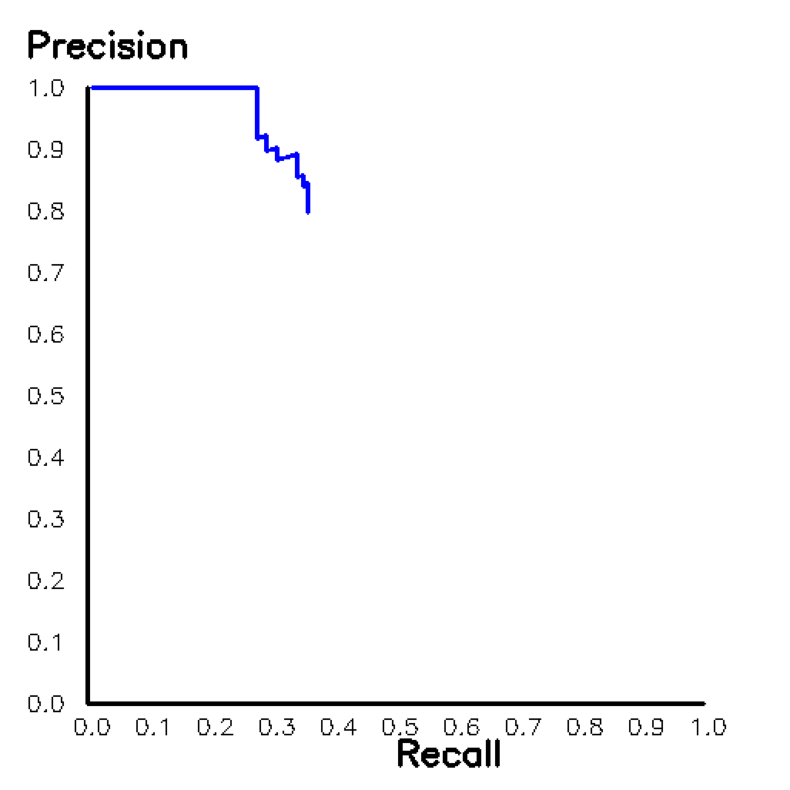


up_view, poop
AP: 0.38153203358977056


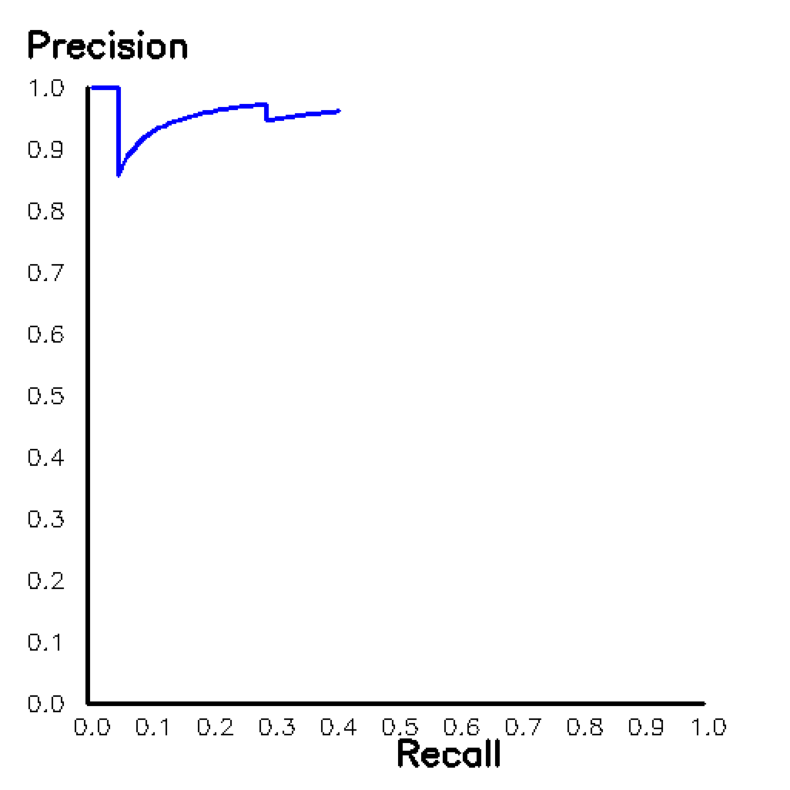


down_view, cable
AP: 0.7540830990733755


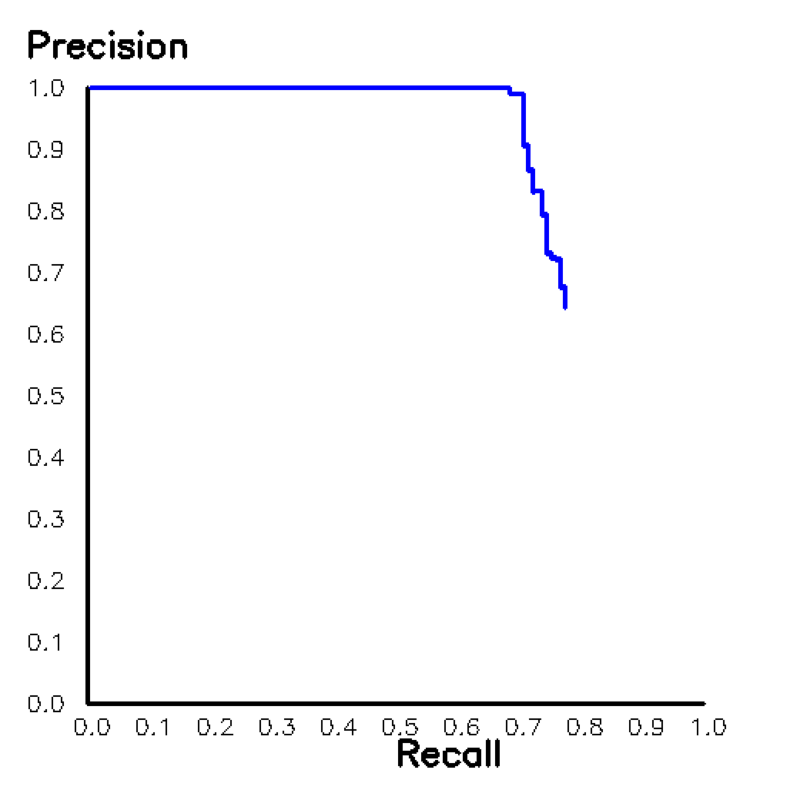


down_view, poop
AP: 0.9136119973208933


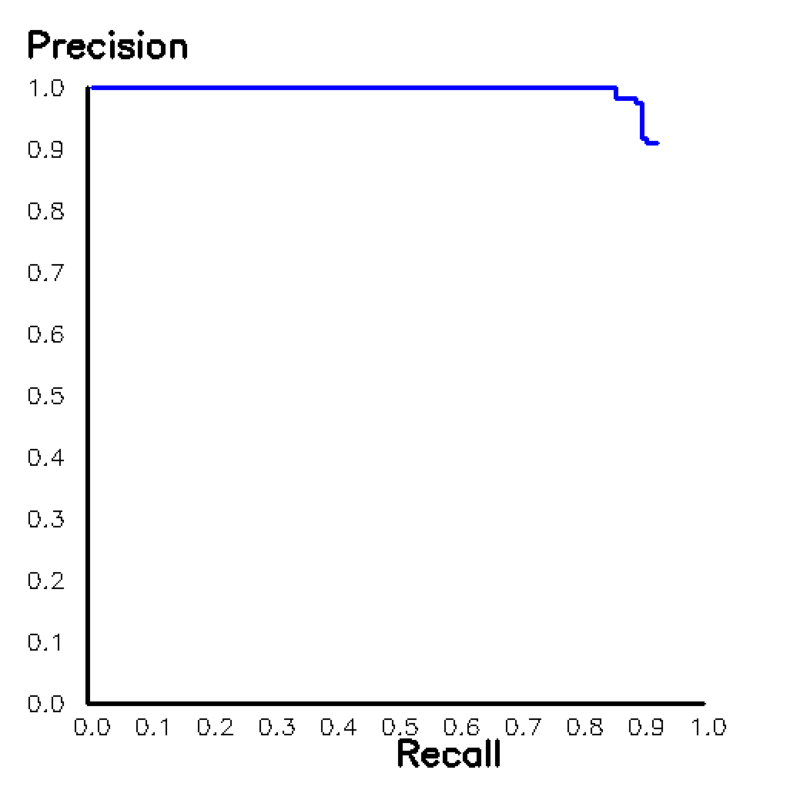

In [6]:
# class별로 AP 성능을 계산하고 그래프를 그린다.
class_list = ['cable', 'carpet', 'cloth', 'liquid', 'poop', 'rack', 'scale', 'socks', 'towel', 'book'] # data.yaml
img_size = {'w':416, 'h':320}
txt2dic_list = Txt2dic_list(class_list, img_size)
cal_mAP = Calculate_mAP(class_list, img_size)
for view in ['up_view', 'down_view']:
    for name in ['cable', 'poop']:
        # img, label list 생성
        file_list = natsorted(os.listdir(f'{dataset_path}/{view}/{name}'))
        img_list, label_list = [], []
        for file in file_list:
            if '.jpg' in file: img_list.append(file)
            elif '.txt' in file: label_list.append(file)
            else: print('파일명 에러 발생')
        # 인퍼런스 하여 GT와 함께 결과 저장
        gt_and_inf_list = []
        for img_name, label_name in zip(img_list, label_list):
            # 파일명 다를 시 에러 출력
            if img_name.split('.')[0] != label_name.split('.')[0]:
                print('img_name != label_name 에러!')
                print(f'img_name: {img_name}, label_name: {label_name}')
                break
            # 인퍼런스
            img = cv2.imread(f'{dataset_path}/{view}/{name}/{img_name}')
            dic_list = model.detect(img, conf_thresh=0.01, filter=[name])
            # GT dic_list 취득
            dic_list_gt = txt2dic_list.transform(f'{dataset_path}/{view}/{name}/{label_name}')
            gt_and_inf_list.append({'dic_list':dic_list, 'dic_list_gt':dic_list_gt})
        # 결과 분석: PR커브 취득, AP 계산
        pr_curve, AP = cal_mAP.process(gt_and_inf_list)
        print(f'{view}, {name}')
        print(f'AP: {AP}')
        show_matplot(pr_curve, img_size={'w':500, 'h':500})
        print('')